# pyfabric
Fabric tensor from 3D images.

`pyfabric` computes the 3D spatial Auto Correlation Function (**ACF**) of an image to extract local orientation and anisotropy.

The **ACF** of an image I is computed in the Fourier domain as: \
$ACF = |IFFT(FFT(I) conj(FFT(I)))|$


Where $FFT()$ and $IFFT()$ are the discrete Fourier and discrete inverse Fourier transforms of the image I, respectively [[1]](http://dx.doi.org/10.1016/j.actbio.2013.05.015) [[2]](https://doi.org/10.1117/12.596133) [[3]](https://doi.org/10.1016/j.bone.2009.07.001).
After this step, the ACF is segmented and an ellipsoid is fitted to its contour. The fabric tensor is obtained from the eigenvalues and eigenvectors of this ellipsoid. \
For a detailed explanation of the method see the example []()


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from ciclope.recon_utils import read_tiff_stack, plot_midplanes
from pyfabric import pyfabric as pf

astropy module not found


In [2]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 6}

plt.rc('font', **font)

In [3]:
%%html
<style>
table {float:left}
</style>

#### Read input data

In [4]:
# Insect scan
input_file = '/home/gianthk/Data/StefanFly_test/test_00__rec/test_00__rec/recon_00000.tiff'

In [5]:
# Read 3D data
data_3D = read_tiff_stack(input_file)

Inspect dataset

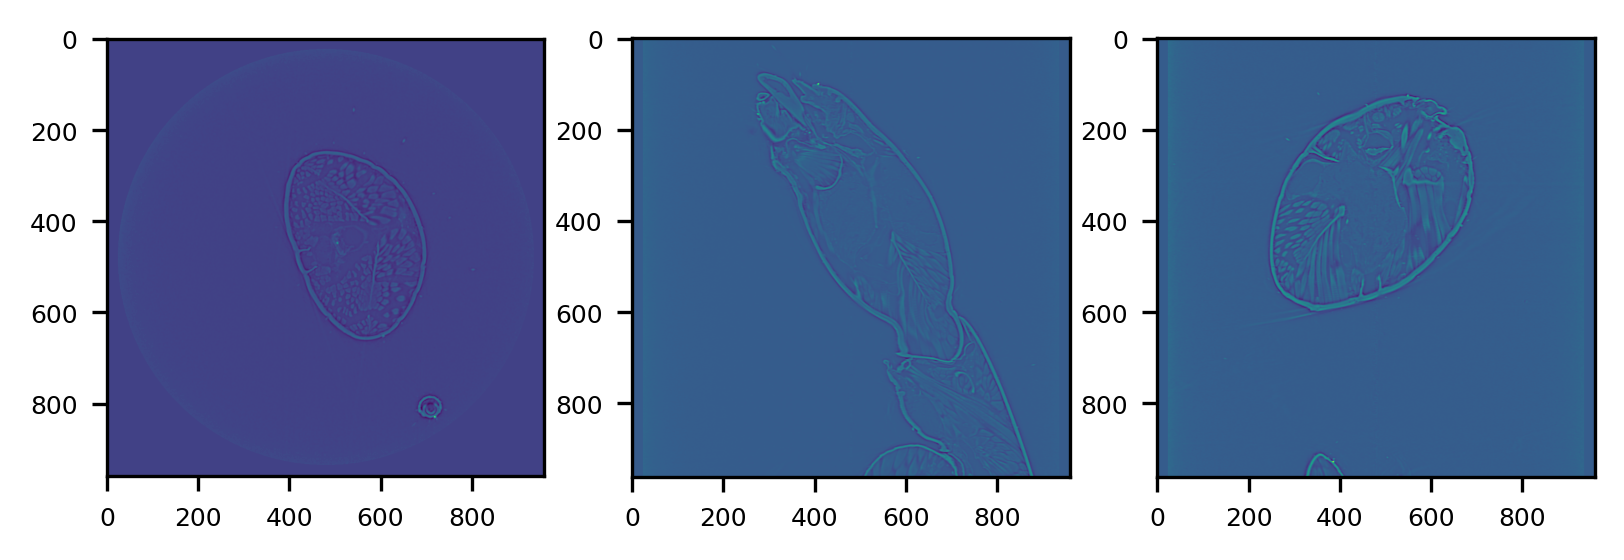

In [6]:
plot_midplanes(data_3D)
plt.show()

Extract Region Of Interest of instect muscle

In [7]:
center = [649, 461, 522]
ROIsize = 50
ROIsize = int(ROIsize/2)
ROI = data_3D[center[2]-ROIsize:center[2]+ROIsize, center[1]-ROIsize:center[1]+ROIsize,center[0]-ROIsize:center[0]+ROIsize]

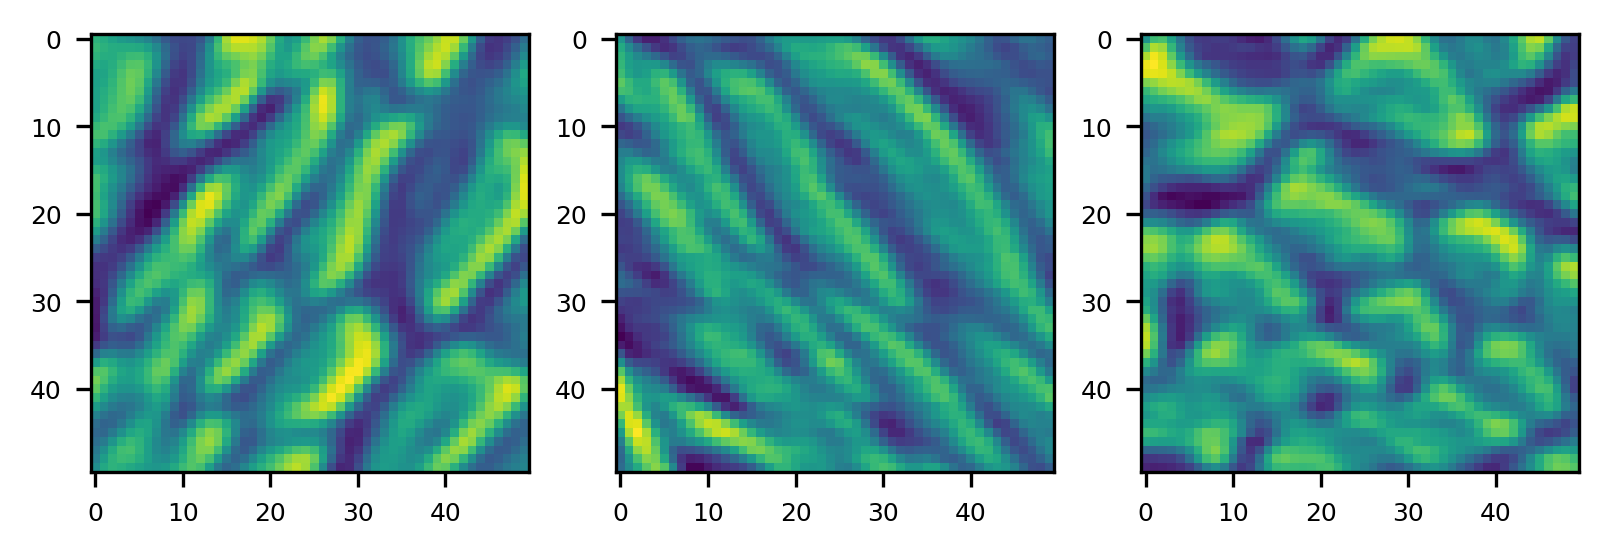

In [8]:
plot_midplanes(ROI)
plt.show()

### Compute image Auto Correlation Function (ACF)

Compute the N-dimensional discrete Fourier Transform $Ev$ of the image **ROI**

In [9]:
Ev = np.fft.fftshift(np.fft.fftn(ROI))

Compute $ACF = |Ev^{-1}(Ev(ROI) conj(Ev(ROI)))|$

In [10]:
ACF = np.abs(np.fft.ifftshift(np.fft.ifftn(Ev * np.conj(Ev))))

Inspect the ACF

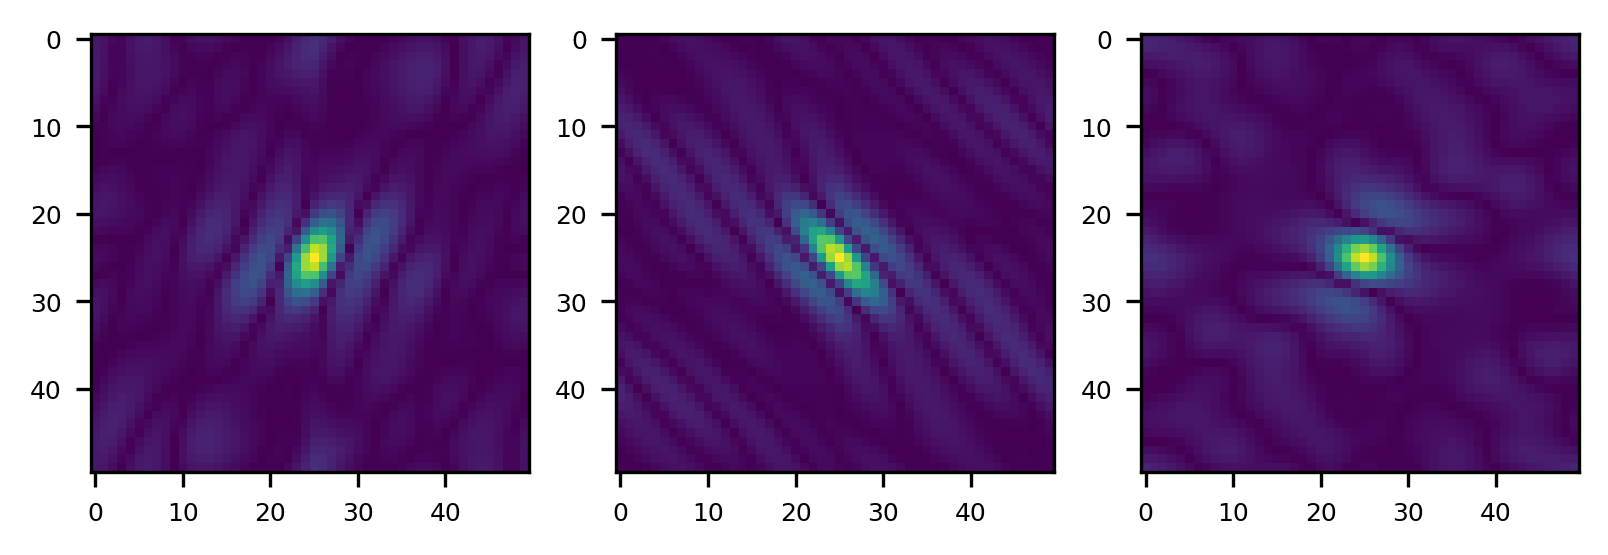

In [11]:
plot_midplanes(ACF)
plt.show()

#### Zoom ACF center
Let's take half of the ACF image along each direction and zoom it with factor 2

In [12]:
from scipy import ndimage

In [13]:
zoom_factor = 2
center = ACF.shape
size = round(min(center)/4)
center = [int(center[0]/2), int(center[1]/2), int(center[2]/2)]

In [14]:
ACFzoom = ndimage.zoom(ACF[center[0]-size:center[0]+size, center[1]-size:center[1]+size, center[2]-size:center[2]+size], zoom_factor, output=None, order=2)

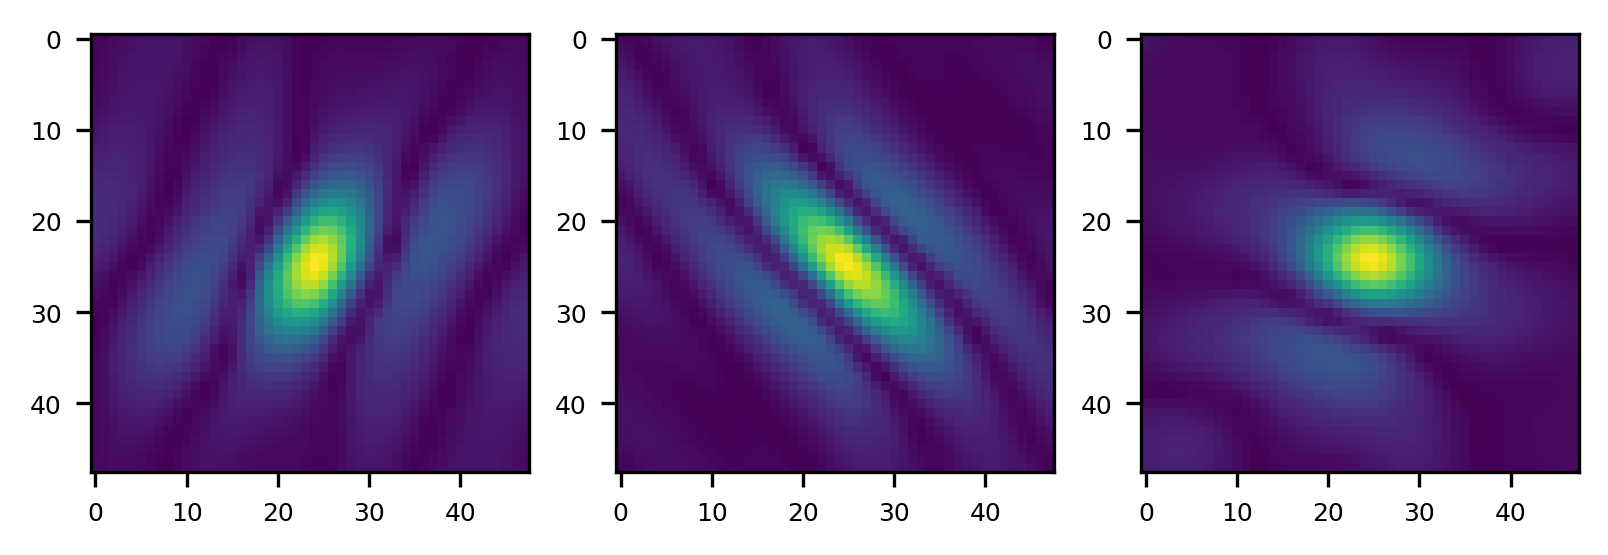

In [15]:
plot_midplanes(ACFzoom)
plt.show()

#### Normalize to 0-1 range

In [16]:
ACFmin = np.min(ACFzoom)
ACFmax = np.max(ACFzoom)
df = ACFmax - ACFmin

In [17]:
ACFnorm = (ACFzoom-ACFmin)/df

Segment the normalized ACF

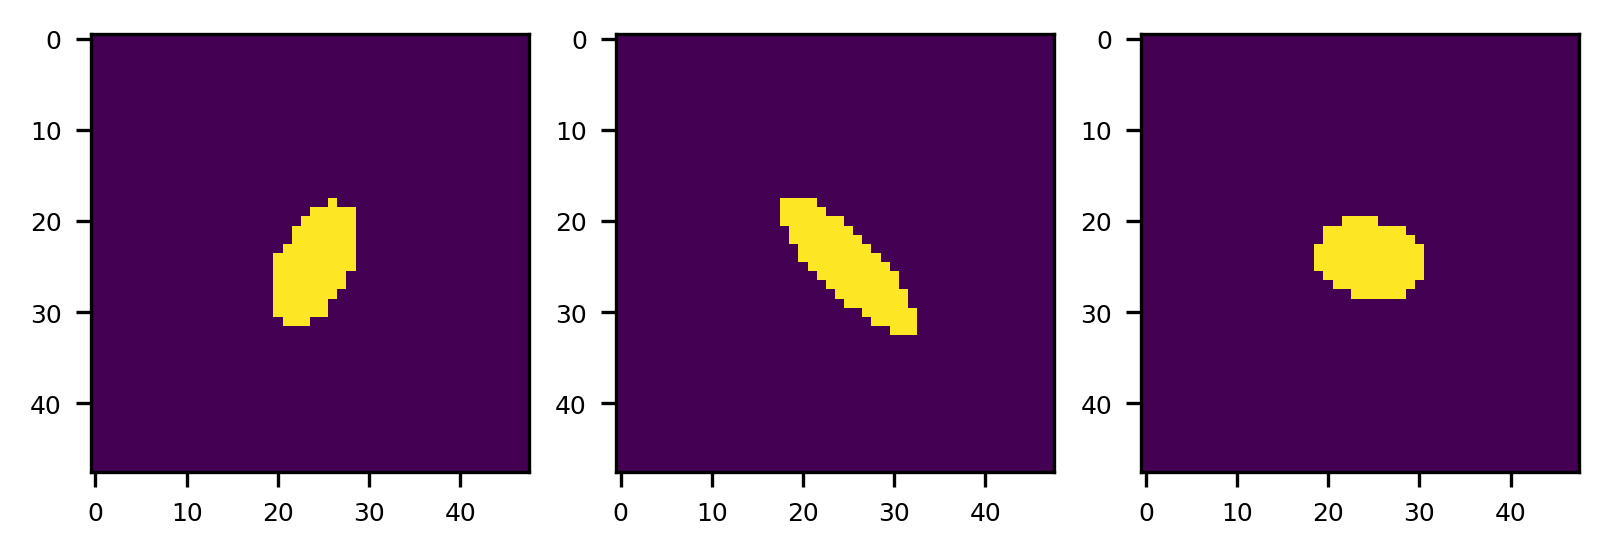

In [18]:
plot_midplanes(ACFnorm>0.5)
plt.show()

#### Extract envelope points on ellipsoid

In [19]:
from skimage.measure import marching_cubes

In [20]:
# coors, triangles, tmp, tmp2 = marching_cubes(np.transpose(ACFnorm>0.5, [2, 1, 0]), level=None, step_size=1)
coors, triangles, tmp, tmp2 = marching_cubes(ACFnorm>0.5, level=None, step_size=1)

Scatter plot of the envelope points

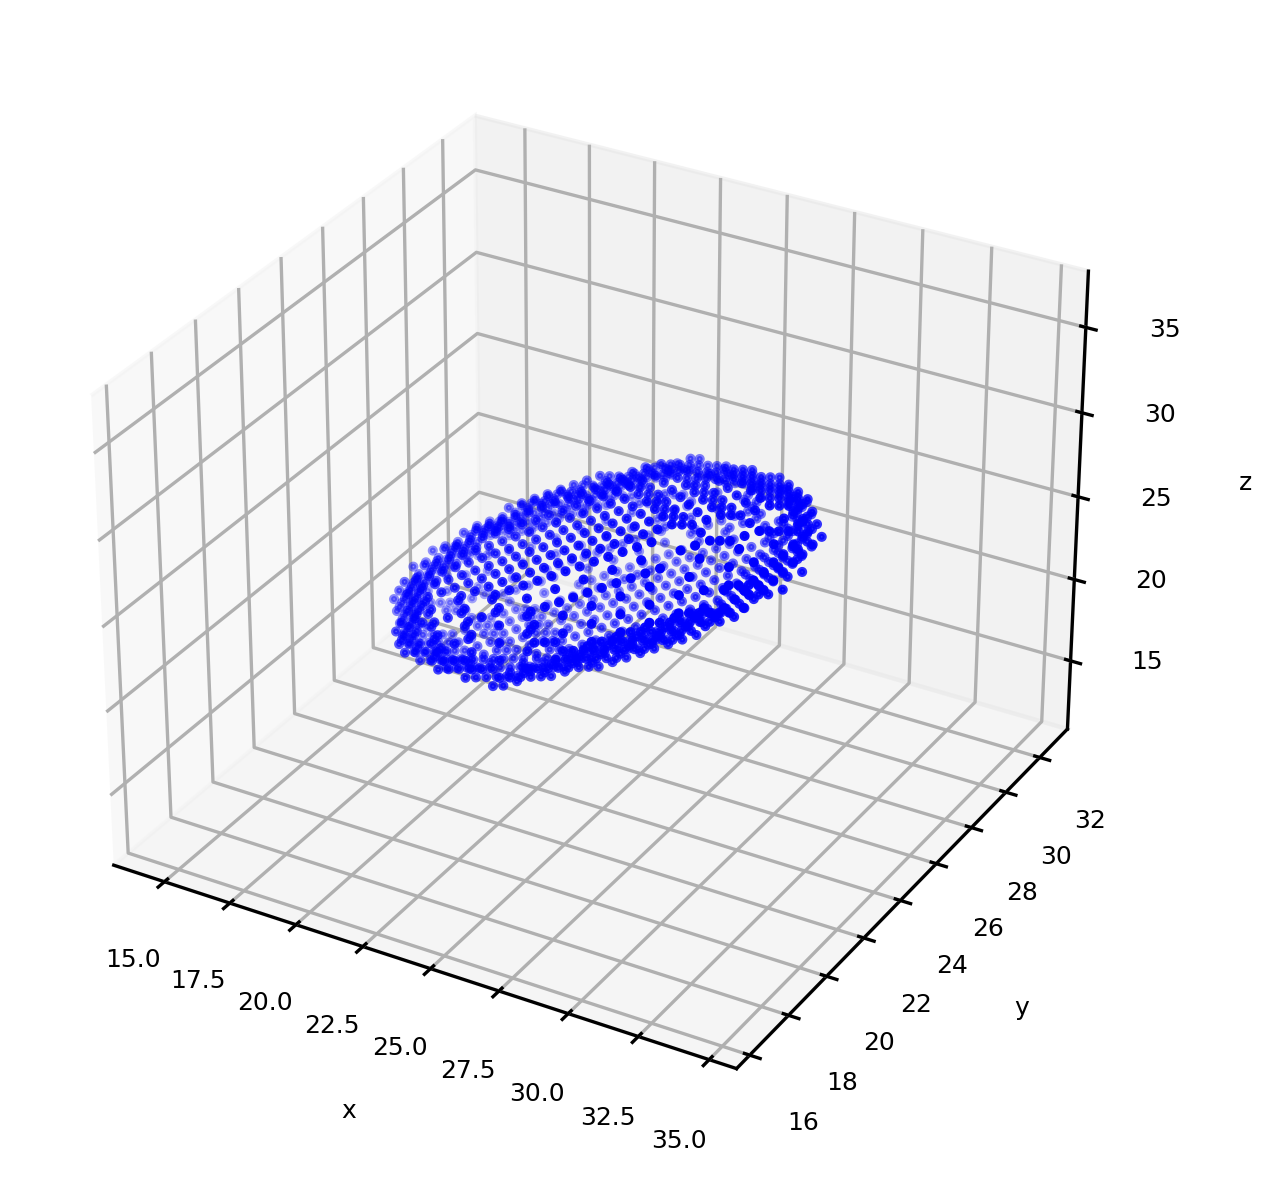

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coors[:,0], coors[:,1], coors[:,2], zdir='z', s=2, c='b',rasterized=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

#### Ellipsoid fit
Performed using the package [ellipsoid_fit_python](https://github.com/aleksandrbazhin/ellipsoid_fit_python). \
See also the [original project](https://it.mathworks.com/matlabcentral/fileexchange/24693-ellipsoid-fit) on Mathworks.



In [22]:
from pyfabric import ellipsoid_fit as ef

In [23]:
center, evecs, radii, v = ef.ellipsoid_fit(coors)

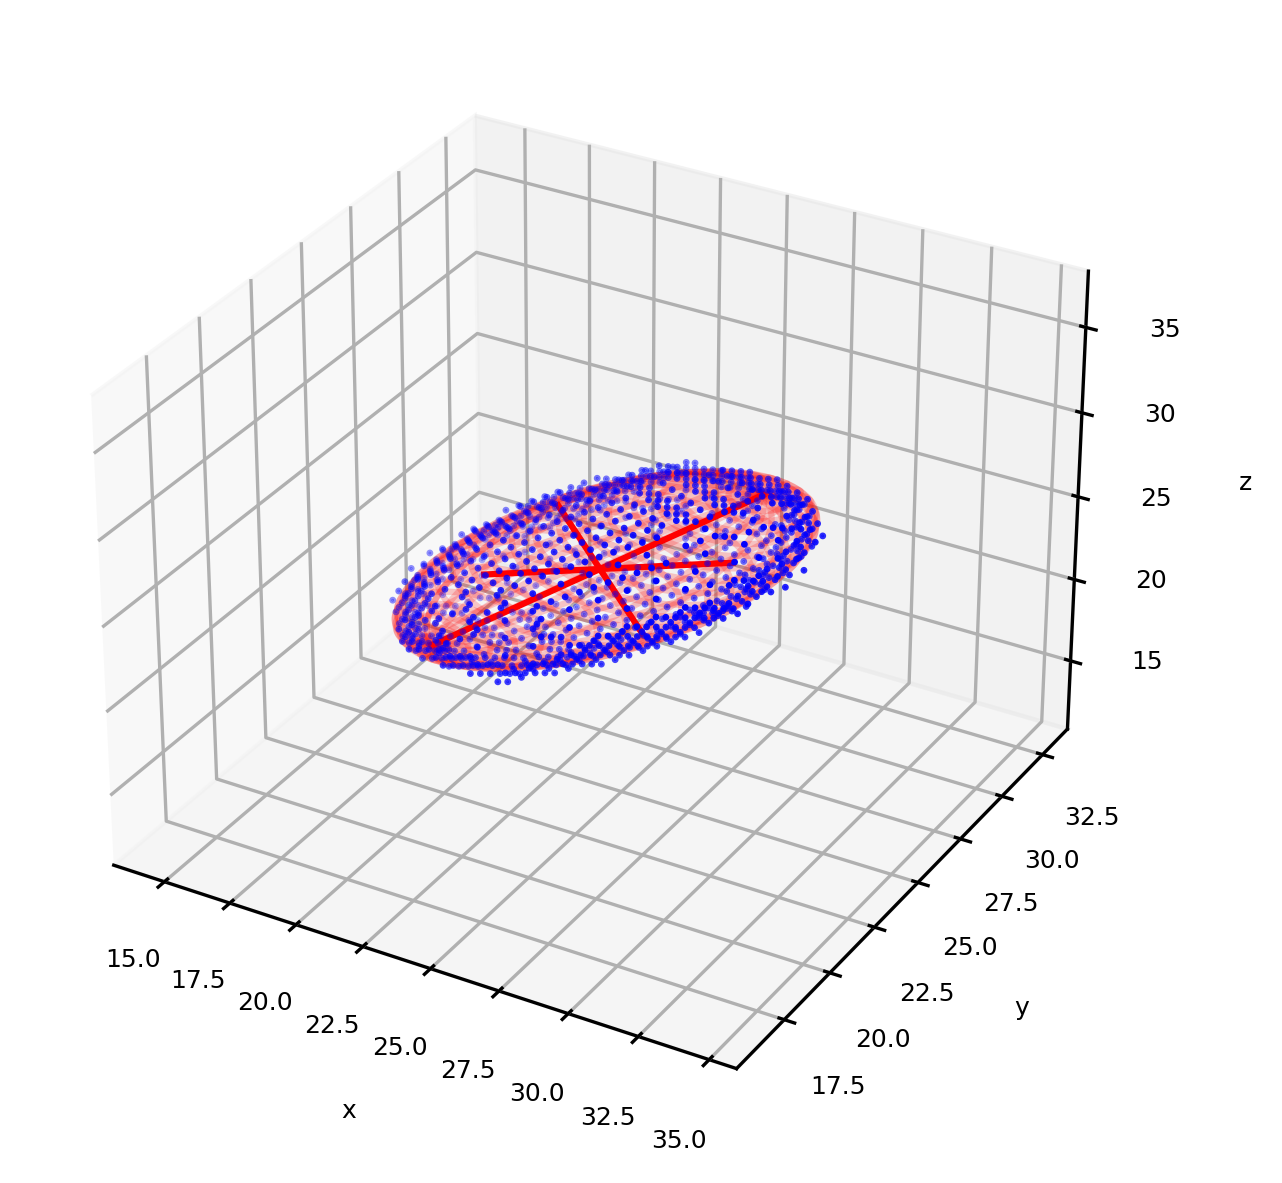

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coors[:,0], coors[:,1], coors[:,2], zdir='z', s=0.4, c='b',rasterized=True)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ef.ellipsoid_plot(center, radii, evecs, ax=ax, plot_axes=True, cage_color='red')
plt.show()

Ellipsoid eigenvalues

In [88]:
evals = 1 / (radii ** 2)

#### Degree of Anisotropy (DA) 
This is the ratio between the largest and smallest radii

In [89]:
DA = np.max(radii) / np.min(radii)
print(DA)

5.1276731911809925


#### Eigen-decomposition of fabric tensor
Compute the components of the symmetric Rank-2 fabric tensor T as:
$F = V A V^{T}$ \
Where $V$ is a 3x3 matrix of the ellipsoid eigenvectors, and $A$ is a diagonal matrix containing the ellipsoid eigenvalues on the diagonal term.

In [90]:
fabric_tens = np.matmul(evecs, np.matmul((evals * np.identity(3)), np.transpose(evecs)))

In [91]:
print(fabric_tens)

[[ 0.06307927 -0.02726832  0.02886669]
 [-0.02726832  0.05155509 -0.03008466]
 [ 0.02886669 -0.03008466  0.02620777]]


General `pyfabric` plot

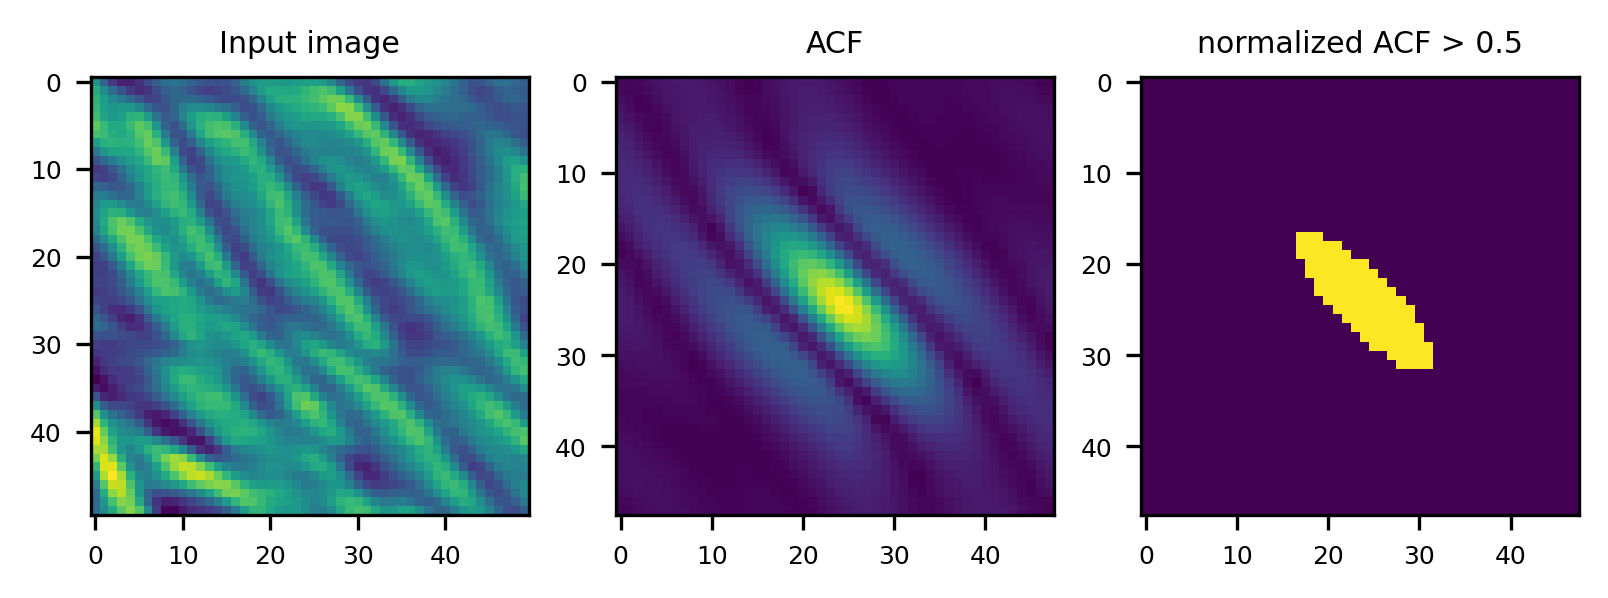

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# fig.suptitle('Horizontally stacked subplots')
ax1.imshow(ROI[:, 25, :])
ax1.set_title('Input image')
ax2.imshow(ACFzoom[:, 25, :])
ax2.set_title('ACF')
ax3.imshow(ACFnorm[:, 25, :]>0.5)
ax3.set_title('normalized ACF > 0.5')
plt.show()